In [1]:
# Standard Python modules
import os, sys
import glob
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.projections import get_projection_class

sys.path.append('../modules')
from timeseries import select_months
import globalvars

In [2]:
path_to_data = globalvars.path_to_data
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
df1 = pd.read_csv(path_to_out+'landslide_box-whisker.csv')
df1.loc[df1["AR_index"] == 5.5, "AR_index"] = 5
df2 = pd.read_csv(path_to_out+'non-landslide_box-whisker.csv')
df2.loc[df2["AR_index"] == 5.5, "AR_index"] = 5
df_lst = [df1, df2]

In [4]:
idx = df2['AR_index'] == 5
df2.loc[idx]

,impact_date,init_date,model_name,F,IVT,Z0,UV,QPF,AR_index
7371,2002-11-26,2002-11-25,GEFSv12_reforecast,24,99.0,99.0,99.0,99.0,5.0
7372,2002-11-26,2002-11-24,GEFSv12_reforecast,48,99.0,99.0,99.0,99.0,5.0
7373,2002-11-26,2002-11-23,GEFSv12_reforecast,72,99.0,99.0,99.0,99.0,5.0
7375,2002-11-26,2002-11-21,GEFSv12_reforecast,120,99.0,99.0,99.0,99.0,5.0
7378,2002-11-27,2002-11-26,GEFSv12_reforecast,24,99.0,99.0,99.0,99.0,5.0
7379,2002-11-27,2002-11-25,GEFSv12_reforecast,48,99.0,99.0,99.0,99.0,5.0
7380,2002-11-27,2002-11-24,GEFSv12_reforecast,72,99.0,99.0,99.0,99.0,5.0
7381,2002-11-27,2002-11-23,GEFSv12_reforecast,96,99.0,99.0,99.0,99.0,5.0
7382,2002-11-27,2002-11-22,GEFSv12_reforecast,120,99.0,99.0,98.0,99.0,5.0
7383,2002-11-27,2002-11-21,GEFSv12_reforecast,144,99.0,99.0,99.0,99.0,5.0


In [9]:
for i, df in enumerate(df_lst):
    ssn = 'all'
    df = df.set_index(pd.to_datetime(df['impact_date']))
    if ssn == 'DJF':
        df = select_months(df, 12, 2)
    elif ssn == 'cool-season':
        df = select_months(df, 10, 5)
    else:
        df = df
    df
    df = df.reset_index(drop=True)
    
    F_lst = np.arange(24, 168+24, 24)
    varlst = ['IVT', 'Z0', 'UV', 'QPF', 'AR_index']
    for j, F in enumerate(F_lst):
        print('F = {0}'.format(F))
        idx = (df.F == F)
        tmp = df.loc[idx]
        tmp = tmp.drop(columns=["impact_date", "init_date", "F"])
        print(tmp.describe())

F = 24
              IVT         Z0          UV         QPF   AR_index
count   99.000000  99.000000   99.000000   99.000000  99.000000
mean    89.808081  65.515152   97.747475   97.818182   2.757576
std     24.024510  40.119811    3.147216    3.623516   1.086474
min      0.000000   0.000000   75.000000   75.000000   1.000000
25%     95.000000   0.000000   98.000000   98.000000   1.750000
50%     98.000000  90.000000   99.000000   99.000000   3.000000
75%     99.000000  95.000000   99.000000   99.000000   3.500000
max    100.000000  99.000000  100.000000  100.000000   5.000000
F = 48
              IVT         Z0         UV         QPF   AR_index
count   99.000000  99.000000  99.000000   99.000000  99.000000
mean    88.212121  64.626263  97.151515   96.515152   2.681818
std     26.991409  39.647577   4.878867   10.494278   1.055729
min      0.000000   0.000000  75.000000    0.000000   1.000000
25%     94.500000   0.000000  98.000000   98.000000   2.000000
50%     98.000000  75.000000  99

In [6]:
def add_box_whisker_plots(fig, df, col, letter_lst):
    #######################
    ### BOX AND WHISKER ###
    #######################
    varname_lst = ['IVT', 'Z0', 'UV', 'QPF', 'AR_index']
    color_lst = ['#54B36D', '#FC5F3F', '#9956AD', '#2171b5', '#F5F0E6']
    row_lst = np.arange(0, 6)
    for i, varname in enumerate(varname_lst):
        ax = fig.add_subplot(gs[row_lst[i], col])
        PROPS = {'boxprops':{'facecolor':color_lst[i], 'edgecolor':'k'},
                 'medianprops':{"color": "k"},
                 'whiskerprops':{"color": "k"},
                 'capprops':{"color": "k"},
                 'flierprops':{"marker": "x"},
                 'meanprops':{'c':'k', 'lw':1},
                 'bootstrap': 5000}
        
        ax = sns.boxplot(y=varname, x="F", data=df, 
                            whis=[0, 100],
                        order=np.arange(24, 8*24, 24),
                        meanline=True, showmeans=True, 
                        notch=False, showcaps=True,
                        linewidth=0.75, ax=ax,
                        **PROPS)
        
        #  set the ticks first
        if varname == 'AR_index':
            ax.set_ylim(0., 6)
            ax.set_yticks(np.arange(0., 6, 1))
        else:
            ax.set_ylim(74, 105)
            # Set ticks 
            ax.set_yticks(np.arange(75, 101, 5)) # major ticks 
            ax.set_yticks(np.arange(75, 101, 1), minor=True) # minor ticks
    
            for k in [0, 3, 4, 5]:
                ax.get_yticklabels()[k].set_color("grey")
    
            # Add custom vertical lines (e.g., at specific data points)
            custom_y_positions = [75, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
            for y_pos in custom_y_positions:
                ax.axhline(y=y_pos, xmin=-0.01, xmax=0.01, color='grey', linestyle='-', linewidth=1.)
            
        if col == 0:
            if i <= 3:
                ax.set_ylabel('{0}'.format(varname))
        
            else:
                ax.set_ylabel('AR Hazard Index')
        else:
            ax.set_ylabel('')
        if row_lst[i] == 5:
            ax.set_xlabel('Lead (hours)')
        else:
            ax.set_xlabel('')
        ax.text(0.02, 0.98, f'({letter_lst[i]})', ha='left', va='top', 
                # backgroundcolor='white',
                transform=ax.transAxes, fontsize=9., zorder=110)

    return fig

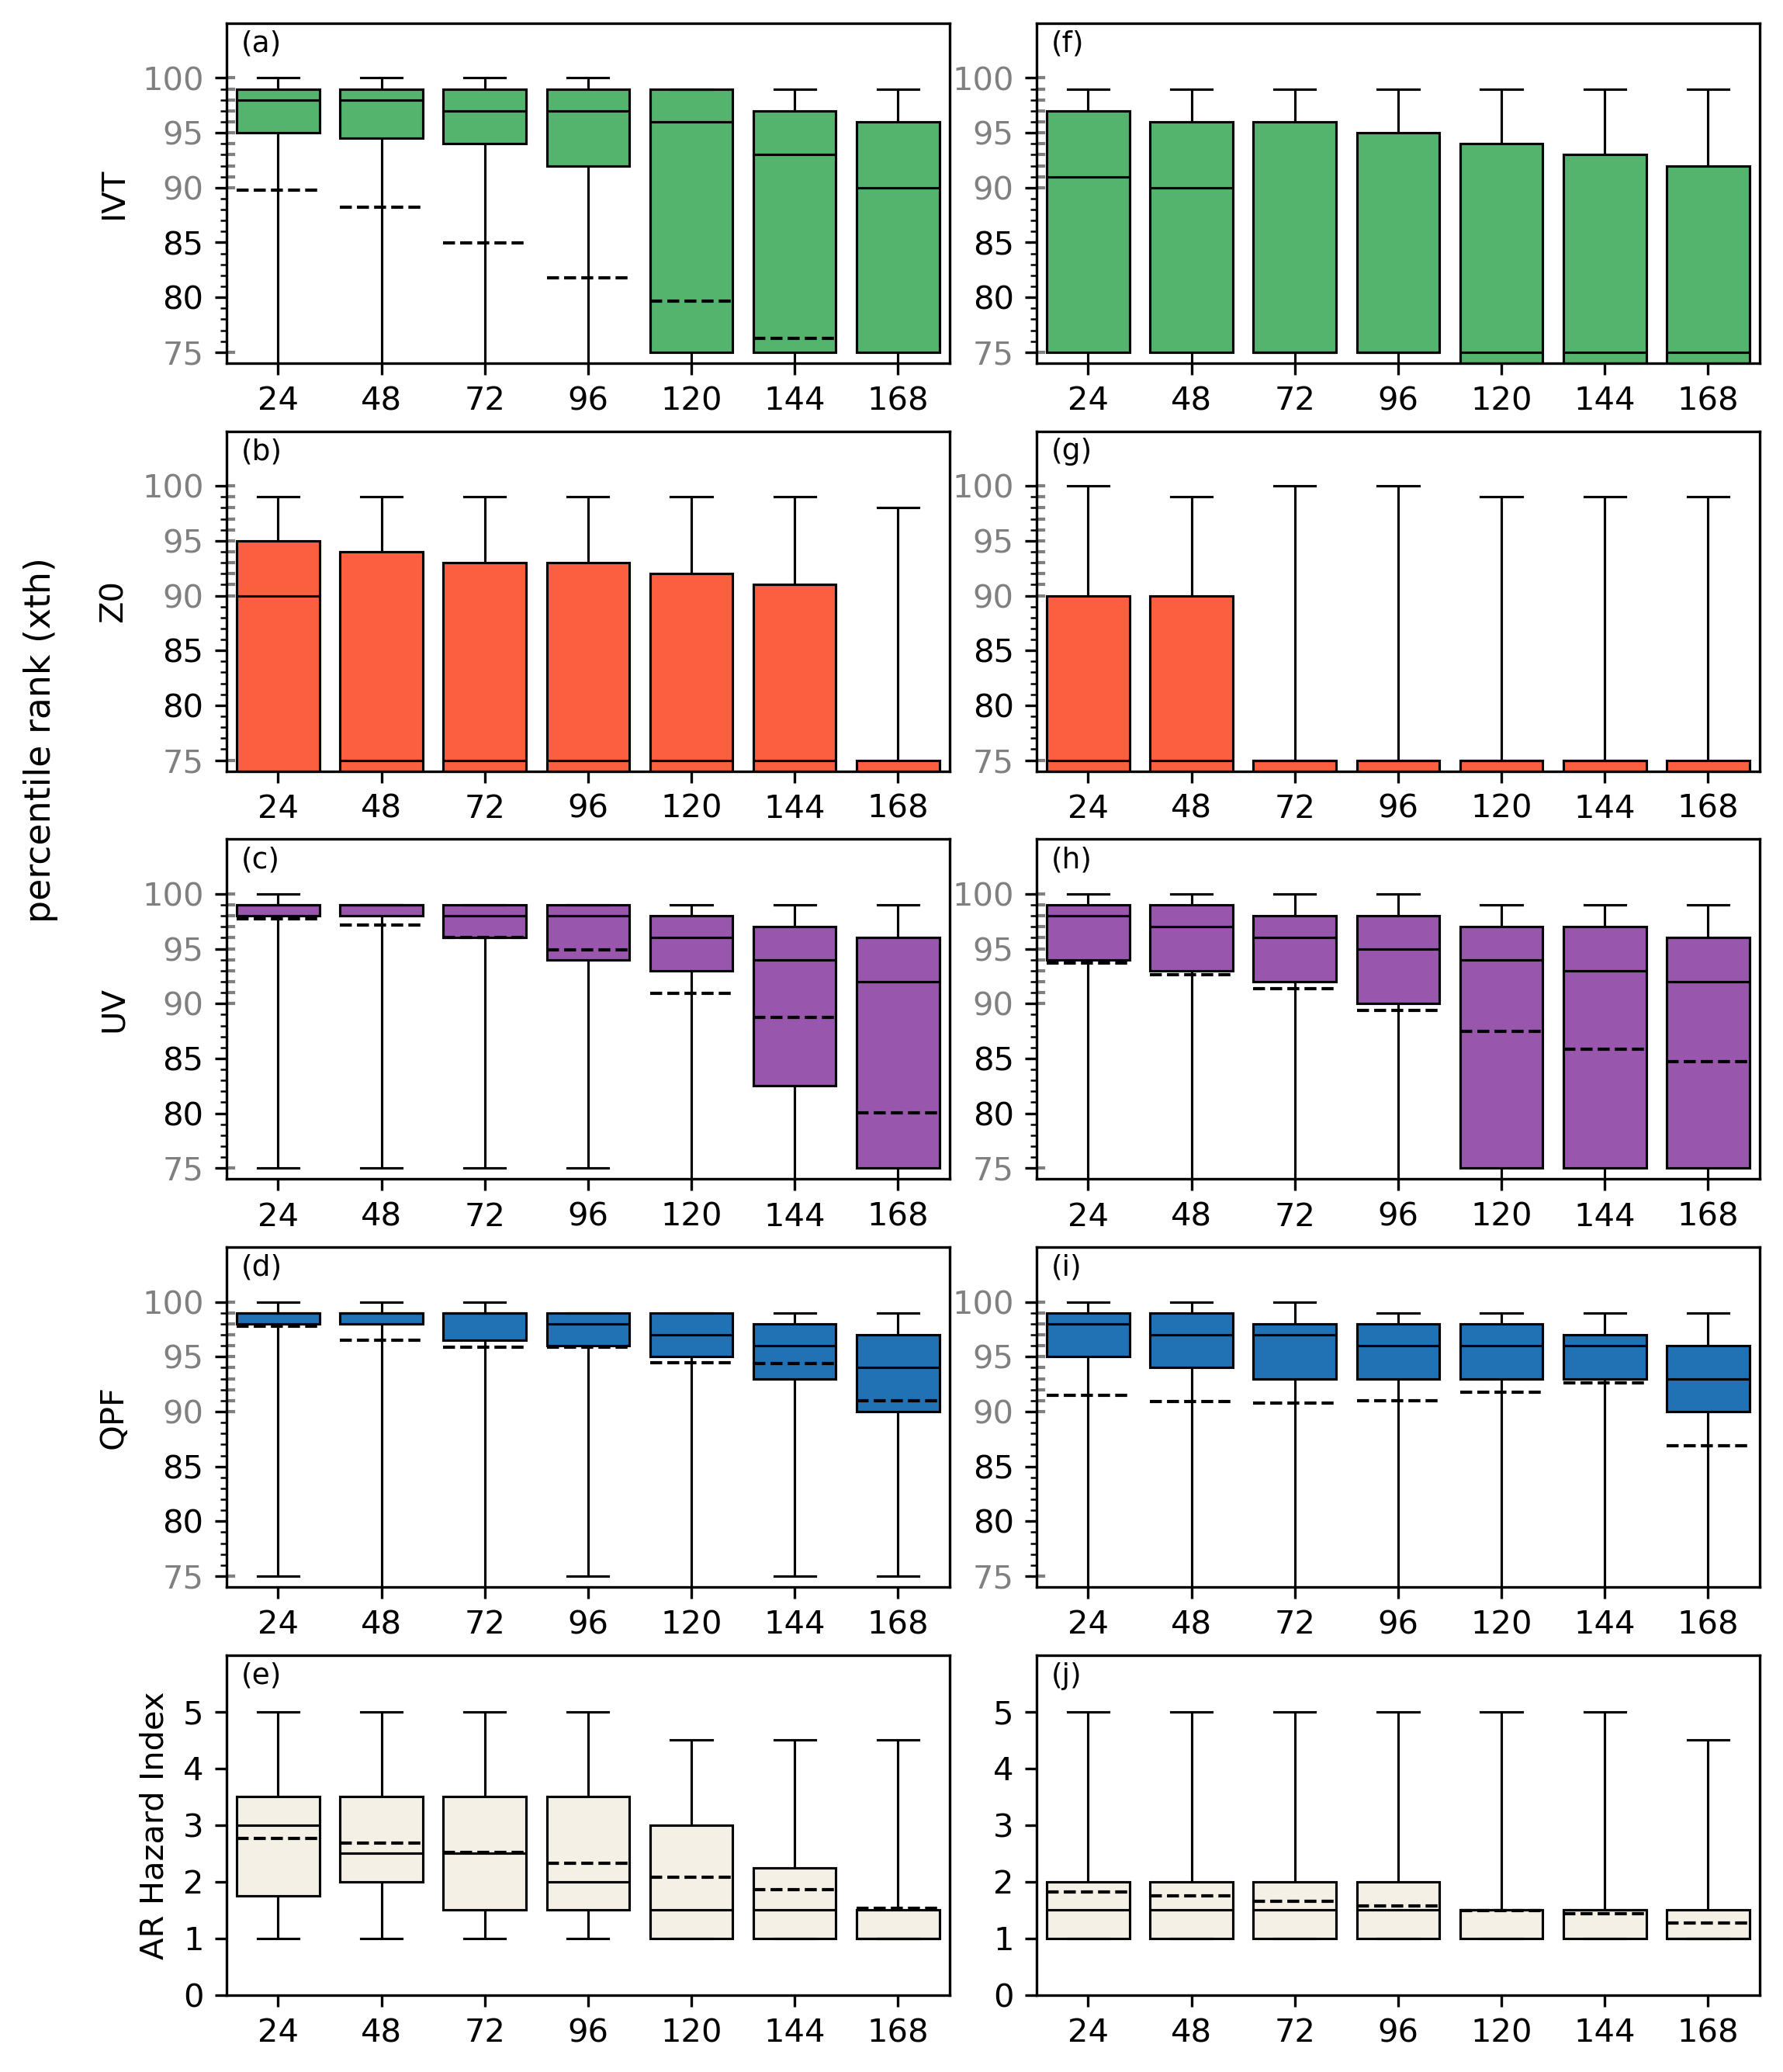

In [7]:
# Create figure
fig = plt.figure(figsize=(8.5, 11))
fig.dpi = 300
fname = path_to_figs + 'box_whisker_{0}'.format(ssn)
fmt = 'png'

nrows = 5
ncols = 2

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 1, 1], width_ratios = [1, 1], wspace=0.12, hspace=0.2)
## use gs[rows index, columns index] to access grids

col_lst = [0, 1]
letters = [['a', 'b', 'c', 'd', 'e'], ['f', 'g', 'h', 'i', 'j']]
## add box and whiskers
for i, (df, col, letter_lst) in enumerate(zip(df_lst, col_lst, letters)):
    fig = add_box_whisker_plots(fig, df, col, letter_lst)

## add horizontal text that says 'percentile rank (xth)'
## centered for top four plots
fig.text(0.04, 0.6, 'percentile rank (xth)', va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor', fontsize=11)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)

# Show
plt.show()